# (Core) Project 1 Revisited: Importances and Coefficients
* Daniel Barella
* 3/23/23

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED = 42
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

In [3]:
df = pd.read_csv('/Users/danielbarella/Downloads/sales_predictions.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
sp_df = df.copy()

In [5]:
sp_df = sp_df.drop(['Item_Identifier','Outlet_Identifier'],axis=1)

In [6]:
sp_df = sp_df.replace({'Item_Fat_Content':{'LF': 'Low Fat','reg': 'Regular','low fat': 'Low Fat'}})
sp_df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [7]:
sp_df['Outlet_Size'] = sp_df['Outlet_Size'].replace('High', 'Large')
sp_df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
Large      932
Name: Outlet_Size, dtype: int64

In [8]:
sp_df.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
## Make x and y variables
y = sp_df['Item_Outlet_Sales'].copy()
X = sp_df.drop(columns = 'Item_Outlet_Sales').copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,2009,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,2009,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,1999,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,2004,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,2002,NaN,Tier 2,Supermarket Type1


In [10]:
## make categorical selector and verify it works 
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [11]:
## make numeric selector and verify it works 
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [12]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

In [13]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1208bd430>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x105cdc610>)],
                  verbose_feature_names_out=False)

In [14]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_Low Fat',
       'Item_Fat_Content_Regular', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Size_Large',
       'Outlet_Size_MISSING', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'], dtype=object)

In [15]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_Large,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,16.35,0.029565,256.4646,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,15.25,0.000000,179.7660,2009.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,12.35,0.158716,157.2946,1999.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_Large,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,14.30,0.026300,79.4302,1987.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2957,7.93,0.071136,42.7086,1997.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7031,14.50,0.041313,42.0454,1999.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
## confirm the first 3 rows index in y_test matches X_test_df
y_test.head(3)

7503    1743.0644
2957     356.8688
7031     377.5086
Name: Item_Outlet_Sales, dtype: float64

In [18]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [19]:
## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.56	RMSE= 1139.10
Test Data:	R^2= 0.57	RMSE= 1092.86


In [20]:
lin_reg.coef_

array([-1.94181707e+00, -4.23390180e+02,  1.57209242e+01,  2.83096799e+01,
       -3.13126168e+01,  3.13126168e+01, -1.86125405e+01, -4.72608587e+01,
        2.67485232e+01,  8.90365370e+00, -1.24947555e+02, -2.03831667e+01,
        2.71414890e+01, -4.71764142e+00,  8.41287319e+00, -1.31027942e+01,
       -3.04774272e+01, -4.54262663e+01,  3.08888596e+02, -4.05449331e+01,
       -5.80982758e+01,  2.34763241e+01,  4.95897145e+02, -2.74294088e+02,
       -8.33530059e+01, -1.38250052e+02,  1.04751265e+02,  5.35796799e+01,
       -1.58330945e+02, -1.55826505e+03, -2.40060062e+01, -4.02580314e+02,
        1.98485137e+03])

In [21]:
## Checking the number of coeffs matches the # of feature names
print(len(lin_reg.coef_))
len(feature_names)

33


33

In [22]:
## Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs

Item_Weight                          -1.941817
Item_Visibility                    -423.390180
Item_MRP                             15.720924
Outlet_Establishment_Year            28.309680
Item_Fat_Content_Low Fat            -31.312617
Item_Fat_Content_Regular             31.312617
Item_Type_Baking Goods              -18.612541
Item_Type_Breads                    -47.260859
Item_Type_Breakfast                  26.748523
Item_Type_Canned                      8.903654
Item_Type_Dairy                    -124.947555
Item_Type_Frozen Foods              -20.383167
Item_Type_Fruits and Vegetables      27.141489
Item_Type_Hard Drinks                -4.717641
Item_Type_Health and Hygiene          8.412873
Item_Type_Household                 -13.102794
Item_Type_Meat                      -30.477427
Item_Type_Others                    -45.426266
Item_Type_Seafood                   308.888596
Item_Type_Snack Foods               -40.544933
Item_Type_Soft Drinks               -58.098276
Item_Type_Sta

In [23]:
# use .loc to add the intercept to the series
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                           -1.941817
Item_Visibility                     -423.390180
Item_MRP                              15.720924
Outlet_Establishment_Year             28.309680
Item_Fat_Content_Low Fat             -31.312617
Item_Fat_Content_Regular              31.312617
Item_Type_Baking Goods               -18.612541
Item_Type_Breads                     -47.260859
Item_Type_Breakfast                   26.748523
Item_Type_Canned                       8.903654
Item_Type_Dairy                     -124.947555
Item_Type_Frozen Foods               -20.383167
Item_Type_Fruits and Vegetables       27.141489
Item_Type_Hard Drinks                 -4.717641
Item_Type_Health and Hygiene           8.412873
Item_Type_Household                  -13.102794
Item_Type_Meat                       -30.477427
Item_Type_Others                     -45.426266
Item_Type_Seafood                    308.888596
Item_Type_Snack Foods                -40.544933
Item_Type_Soft Drinks                -58

In [24]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
coeffs

Item_Weight                            -1.94
Item_Visibility                      -423.39
Item_MRP                               15.72
Outlet_Establishment_Year              28.31
Item_Fat_Content_Low Fat              -31.31
Item_Fat_Content_Regular               31.31
Item_Type_Baking Goods                -18.61
Item_Type_Breads                      -47.26
Item_Type_Breakfast                    26.75
Item_Type_Canned                        8.90
Item_Type_Dairy                      -124.95
Item_Type_Frozen Foods                -20.38
Item_Type_Fruits and Vegetables        27.14
Item_Type_Hard Drinks                  -4.72
Item_Type_Health and Hygiene            8.41
Item_Type_Household                   -13.10
Item_Type_Meat                        -30.48
Item_Type_Others                      -45.43
Item_Type_Seafood                     308.89
Item_Type_Snack Foods                 -40.54
Item_Type_Soft Drinks                 -58.10
Item_Type_Starchy Foods                23.48
Outlet_Siz

In [25]:
sp_df.select_dtypes('object').nunique()

Item_Fat_Content         2
Item_Type               16
Outlet_Size              3
Outlet_Location_Type     3
Outlet_Type              4
dtype: int64

In [26]:
## Make x and y variables
y = sp_df['Item_Outlet_Sales'].copy()
X = sp_df.drop(columns = 'Item_Outlet_Sales').copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.35,Low Fat,0.03,Household,256.46,2009,Medium,Tier 3,Supermarket Type2
7510,15.25,Regular,0.00,Snack Foods,179.77,2009,Medium,Tier 3,Supermarket Type2
5828,12.35,Regular,0.16,Meat,157.29,1999,Medium,Tier 1,Supermarket Type1
5327,7.97,Low Fat,0.01,Baking Goods,82.33,2004,Small,Tier 2,Supermarket Type1
4810,19.35,Low Fat,0.02,Frozen Foods,120.91,2002,NaN,Tier 2,Supermarket Type1


In [27]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_Large,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,14.30,0.03,79.43,"1,987.00",0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
2957,7.93,0.07,42.71,"1,997.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
7031,14.50,0.04,42.05,"1,999.00",1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00


## LinearRegression

In [28]:
## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.56	RMSE= 1139.10
Test Data:	R^2= 0.57	RMSE= 1092.86


In [30]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [31]:
coeffs = get_coeffs_linreg(lin_reg)
coeffs

intercept                         -56,393.76
Outlet_Type_Grocery Store          -1,558.27
Item_Visibility                      -423.39
Outlet_Type_Supermarket Type2        -402.58
Outlet_Size_MISSING                  -274.29
Outlet_Location_Type_Tier 3          -158.33
Outlet_Size_Small                    -138.25
Item_Type_Dairy                      -124.95
Outlet_Size_Medium                    -83.35
Item_Type_Soft Drinks                 -58.10
Item_Type_Breads                      -47.26
Item_Type_Others                      -45.43
Item_Type_Snack Foods                 -40.54
Item_Type_Meat                        -30.48
Outlet_Type_Supermarket Type1         -24.01
Item_Type_Frozen Foods                -20.38
Item_Type_Baking Goods                -18.61
Item_Type_Household                   -13.10
Item_Type_Hard Drinks                  -4.72
Item_Weight                            -1.94
Item_Type_Health and Hygiene            8.41
Item_Type_Canned                        8.90
Item_MRP  

In [32]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), 
                intercept=False,  intercept_name = "intercept", 
                annotate=False, ha='left',va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept==False) & ( intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext, textcoords=textcoords)
    return ax

In [34]:
def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

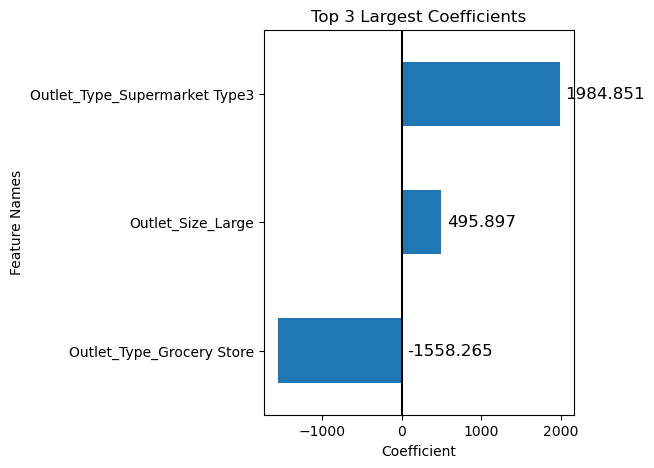

In [36]:
plot_coeffs(coeffs, top_n=3, annotate=True);
plt.savefig('LinearRegression.png', dpi=300, bbox_inches='tight')


- Outlet_Type_Supermarket Type3 - The presence of supermarkets of type 3 has the biggest positive impact on sales of products.

- Outlet_Size_Large - The larger the outlet, the higher the sales of products. This may be because larger outlets typically offer more product options for customers.

- Outlet_Type_Grocery Store - Grocery store outlet types have a negative impact on sales compared to other types of outlets. This could be due to a limited selection of products or other factors such as location or marketing strategies that are less effective for grocery stores.


## Tree-Based Model

In [37]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [38]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [39]:
## Make x and y variables
y = sp_df['Item_Outlet_Sales'].copy()
X = sp_df.drop(columns = 'Item_Outlet_Sales').copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.35,Low Fat,0.03,Household,256.46,2009,Medium,Tier 3,Supermarket Type2
7510,15.25,Regular,0.00,Snack Foods,179.77,2009,Medium,Tier 3,Supermarket Type2
5828,12.35,Regular,0.16,Meat,157.29,1999,Medium,Tier 1,Supermarket Type1
5327,7.97,Low Fat,0.01,Baking Goods,82.33,2004,Small,Tier 2,Supermarket Type1
4810,19.35,Low Fat,0.02,Frozen Foods,120.91,2002,NaN,Tier 2,Supermarket Type1


In [40]:
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_Large,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,14.30,0.03,79.43,"1,987.00",0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
2957,7.93,0.07,42.71,"1,997.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
7031,14.50,0.04,42.05,"1,999.00",1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00


In [45]:
reg = RandomForestRegressor()
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df,y_test)
## Saving the feature importances
importances = get_importances(reg,sort=True,ascending=False)
importances


Training Data:	R^2= 0.94	RMSE= 428.11
Test Data:	R^2= 0.55	RMSE= 1120.33


Item_MRP                          0.45
Outlet_Type_Grocery Store         0.19
Item_Visibility                   0.10
Outlet_Type_Supermarket Type3     0.06
Item_Weight                       0.05
Outlet_Establishment_Year         0.04
Item_Fat_Content_Regular          0.01
Item_Type_Snack Foods             0.01
Item_Type_Fruits and Vegetables   0.01
Outlet_Size_Small                 0.01
Item_Type_Dairy                   0.01
Item_Type_Household               0.01
Item_Type_Soft Drinks             0.01
Item_Type_Frozen Foods            0.01
Outlet_Size_MISSING               0.00
Outlet_Location_Type_Tier 1       0.00
Outlet_Size_Medium                0.00
Item_Type_Canned                  0.00
Item_Type_Baking Goods            0.00
Item_Type_Health and Hygiene      0.00
Item_Type_Meat                    0.00
Outlet_Location_Type_Tier 2       0.00
Outlet_Location_Type_Tier 3       0.00
Item_Type_Starchy Foods           0.00
Item_Type_Hard Drinks             0.00
Item_Type_Breads         

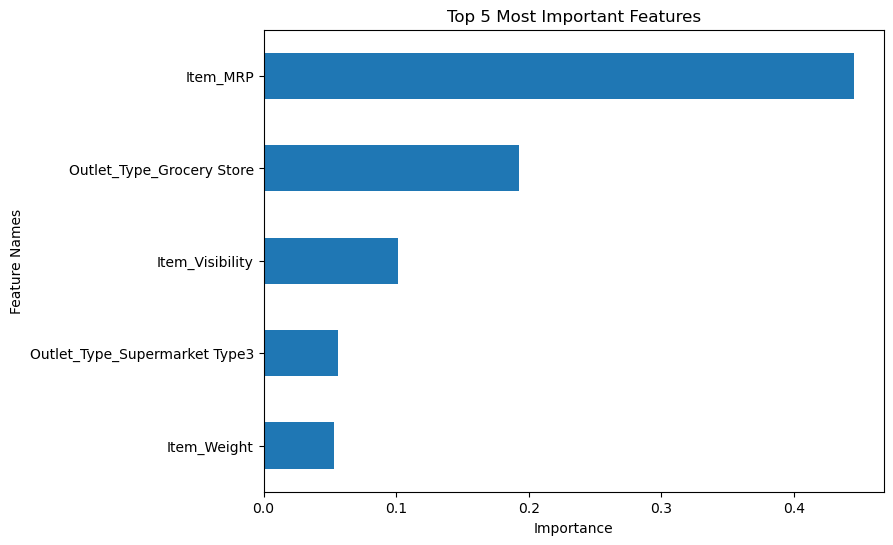

In [44]:
plot_importance(importances, top_n=5);
plt.savefig('RandomForestRegressor.png', dpi=300, bbox_inches='tight')

- Item_MRP: This is the most important feature, which means the price of the item has the strongest impact on sales. A higher price may result in higher sales if the product is perceived as high-quality.

- Outlet_Type_Grocery Store: This feature has a positive impact on sales, which means that having a grocery store outlet type is correlated with higher sales. This could be due to various factors like location or product selection that are more effective for grocery stores.

- Item_Visibility: The visibility of the item on the shelves is another important factor affecting sales. Higher visibility may result in more purchases as customers are more likely to notice the product.

- Outlet_Type_Supermarket Type3: This feature has a positive impact on sales, indicating that supermarket type 3 has a higher impact on sales compared to other types of outlets. Supermarket type 3 may have a larger selection of products or other factors that lead to more sales.

- Item_Weight: The weight of the item also affects sales, but to a lesser extent than the other features. This could be due to various factors like customer preferences or perceived value based on weight.

In [46]:
## saving variables for next lesson/notebook
import joblib
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train':y_train,
         'X_test':X_test_df,
          "y_test":y_test,
         'preprocessor':preprocessor,
         'LinearRegression':lin_reg,
         'RandomForestRegressor':reg}
joblib.dump(export, 'best-models.joblib')

['best-models.joblib']